In [5]:
from __future__ import print_function
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.stats import zscore
import seaborn as sns
%matplotlib  inline

### to do :
Expressions

 1). Match Entrez gene IDs, not HUGO symbols

 2). log2(x+1) or log2(x+min_x/2)
 
 <s>3). why METABRIC looks like array? </s> -- these are microarrays indeed 

Annotations 

 4). add survival to annotations
 
 5). add HER2, PR,ER 
 
 6). add covariates to annotations - e.g. sequencing center 

# TCGA-BRCA 

There are three datasources for TCGA-BRCA: 
   - GDC - the main TCGA repository, contains all intermidiate files of RNA-seq processing 
   - cBioportal 
   - FireBrowse 

### cBioportal  - TCGA BRCA PanCan 2018 - 1081 tumor sample with annotation
    - RNA-seq RSEM 
    1). data_expression_merged.txt - mRNA Expression Batch Normalized/Merged from Illumina HiSeq_RNASeqV2 syn4976369
    2). data_expression.txt -  mRNA Expression from Illumina HiSeq_RNASeqV2; profile_description: mRNA Expression from Illumina HiSeq: https://www.synapse.org/#!Synapse:syn4874822.6
    These matrices looks the same, most of values fully match with rare exceptions: e.g. rna_seq_m.ix[[155060]][["TCGA-3C-AALI-01"]].values[0][0] and rna_seq.ix[[155060]][["TCGA-3C-AALI-01"]].values[0][0]



In [6]:
def plot_n_samples(alldata,n=10,label=""):
    if type(n) == list:
        # if sample names are given, get these sanples
        df = alldata[n]
        samples = n
    else:
        # random n columns from data
        df = alldata.sample(n,axis=1)
        samples = df.columns.values
    #print(n,type(n),samples)
    # Iterate through the five airlines
    plt.figure(figsize=(20,5))
    for sample in samples:
        # Draw the density plot
        sns.distplot(df[sample], hist = True, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = sample,norm_hist=True)

    # Plot formatting
    #plt.legend(prop={'size': 16}, title = 'Sample')
    plt.legend()
    plt.title('Density Plot for random N samples')
    plt.xlabel(label)
    plt.legend("")
    plt.ylabel('Density')
    return list(samples)


In [7]:
def filter_and_preprocess(data_dir,file_name,no_log2=False,no_zscore=False,plot_n_random=0):
    rna_seq = pd.read_csv(data_dir+file_name,sep="\t",index_col=[0,1])
    print("Initially")
    print("samples:",len(rna_seq.columns.values),"genes:",len(rna_seq.index.values))
    # how many nans,infs and zeroes
    nans = rna_seq[np.isnan(rna_seq)].count().sum()
    infs = rna_seq[np.isinf(rna_seq)].count().sum()
    nulls = rna_seq[rna_seq==0].count().sum()
    print("Bad values found:\n",
          "NaN:",nans,"/",nans*100.0/rna_seq.shape[0]/rna_seq.shape[1],"%",
          "Inf:",infs, "/",infs*100.0/rna_seq.shape[0]/rna_seq.shape[1],"%",
          "0:",nulls,"/",nulls*100.0/rna_seq.shape[0]/rna_seq.shape[1],"%")
    #fill NA
    print("NaNs will be replaced with zeroes")
    rna_seq.fillna(0,inplace=True)
    # drop rows with > 50% NAs
    #rna_seq.dropna(inplace=True,axis=1,how="all")
    min_non_NA =  float(rna_seq.shape[1])*0.05
    good_genes = rna_seq.apply(lambda row : len([x for x in row.values if not x==0]) > min_non_NA,axis=1)
    good_genes = good_genes[good_genes==True].index 
    rna_seq = rna_seq.loc[good_genes]
    print("After removal of rows with > 95% 0s")
    print("samples:",len(rna_seq.columns.values),"genes:",len(rna_seq.index.values))

    # drop duplicates
    rna_seq.drop_duplicates(inplace=True)
    print("After removal of duplicated rows")
    print("samples:",len(rna_seq.columns.values),"genes:",len(rna_seq.index.values))
    
    # plot distriution of input data 
    samples = plot_n_random
    if plot_n_random>0:
            samples = plot_n_samples(rna_seq,n=plot_n_random,label='input')
    # log2 -transform , 0.01
    if not no_log2:
        rna_seq = rna_seq.applymap(lambda x: np.log2(x+1))
        
        """# get minimal non-zero expression
        min_exprs = rna_seq[rna_seq!=0].min().min()
        print("log2(x+1/2min_x) transformation, where min_x=",min_exprs)
        # add half of min expression to each 
        rna_seq = rna_seq.applymap(lambda x: np.log2(x+min_exprs*0.5))
        'log2(x+min_x/2)'"""
        
        if plot_n_random>0:
            samples = plot_n_samples(rna_seq,n=plot_n_random,label='log2(x+1)')
        
    if not no_zscore:
        # z-scores for genes in the row of samples
        print("z-score in rows")
        rna_seq_z = rna_seq.T.apply(zscore).T
        if plot_n_random>0:
            samples = plot_n_samples(rna_seq_z,n=samples,label='z-scores')
        return rna_seq_z
    return rna_seq

Initially
samples: 1081 genes: 20531
Bad values found:
 NaN: 0 / 0.0 % Inf: 0 / 0.0 % 0: 3184971 / 14.3505876428 %
NaNs will be replaced with zeroes
After removal of rows with > 95% 0s
samples: 1081 genes: 19436
After removal of duplicated rows
samples: 1081 genes: 19436


/home/olya/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


z-score in rows


,,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
Hugo_Symbol,Entrez_Gene_Id,,,,,,,,,,,,,,,,,,,,,
NaN,100133144,1.063150,0.433742,0.681241,0.724709,0.111944,-0.430400,-1.274969,0.990305,0.462772,0.520473,...,-1.952820,-0.355117,-2.355067,-0.102112,-2.355067,-2.355067,0.918278,1.416490,-0.938534,0.117987
UBE2Q2P2,100134869,1.007042,1.431350,0.533963,0.788621,1.163474,1.079756,0.498584,1.159867,0.819273,-0.432444,...,1.157726,0.763426,-0.874069,1.157636,0.019147,-0.808368,1.737160,2.091052,0.212622,1.949574
HMGB1P1,10357,-1.702363,-1.005222,0.910277,0.740821,-0.552185,0.183722,0.037926,0.228341,-1.356228,0.892134,...,0.598123,0.607113,-3.016268,0.464151,-1.635552,-2.203821,0.636204,-1.206606,-0.528472,1.109838
NaN,10431,-2.531478,-1.637461,0.800104,-0.452216,-0.788835,-0.643417,0.918896,-1.213645,-0.114416,0.171437,...,1.196154,2.881926,1.451548,-1.048677,0.554465,1.690979,-1.232752,-0.951109,0.310681,-0.042761
LOC155060,155060,2.671995,1.490469,1.685199,1.587888,0.524204,0.605553,-1.207522,0.623236,-1.078802,-1.238292,...,0.549108,0.023607,1.755229,2.099829,0.632237,1.931944,1.222590,1.043636,0.475749,0.394619


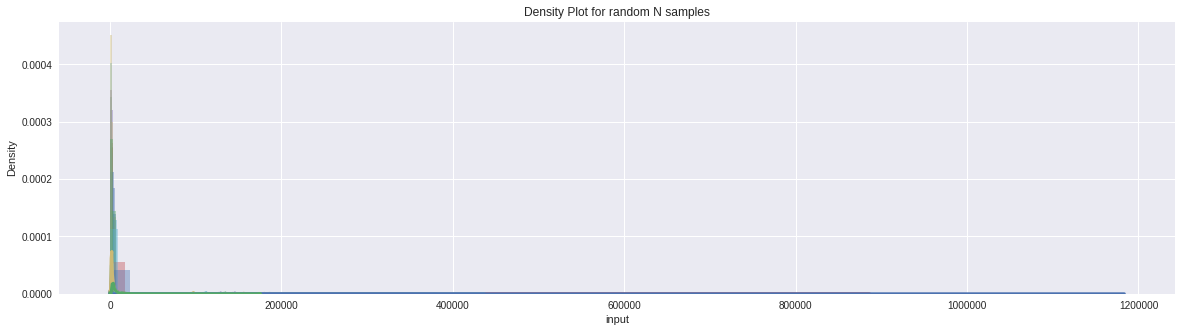

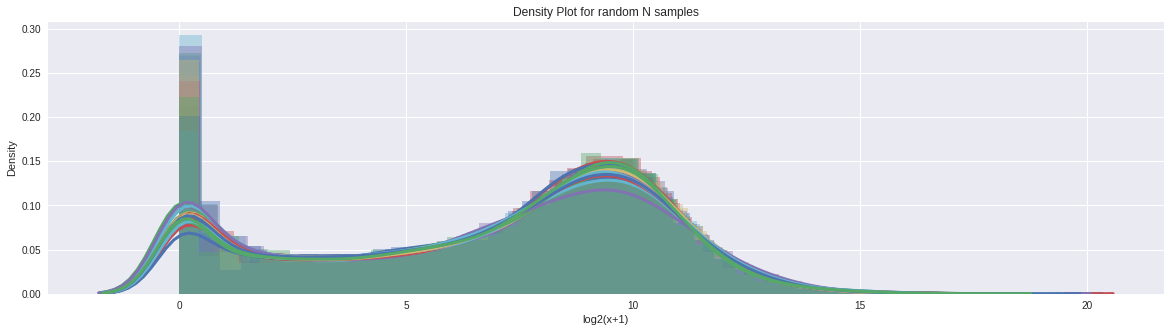

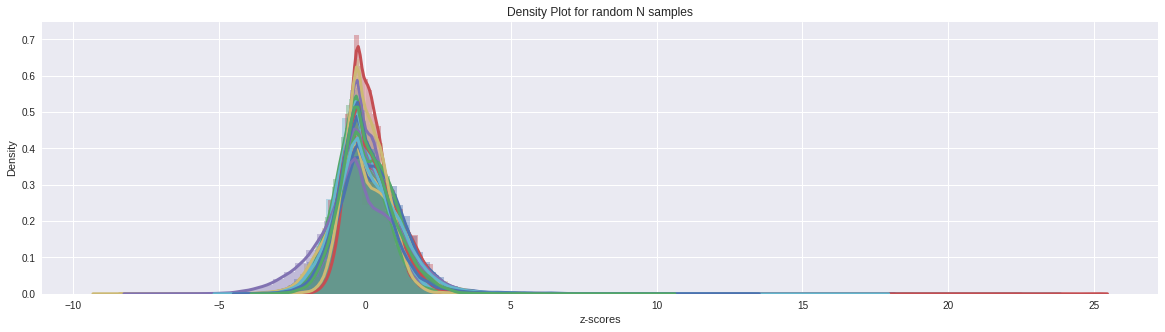

In [8]:
data_dir="Expression/TCGA-BRCA/cbioportal/brca_tcga_pan_can_atlas_2018/";
file_name = "data_expression.txt"

tcga_rnaseq = filter_and_preprocess(data_dir,file_name,plot_n_random=20)
tcga_rnaseq.head()

In [12]:
"""for row, rowz in zip(rna_seq.head(10).iterrows(),rna_seq_z.head(10).iterrows()):
    plt.figure(1,figsize=(20,5))
    plt.subplot(121)
    plt.hist(row[1],bins=50)
    plt.title(row[0])
    plt.subplot(122)
    plt.hist(rowz[1],bins=50)
    plt.title(str(rowz[0])+"zcore")
    plt.show()"""
"""plot_n_samples(tcga_rnaseq,n=['TCGA-AC-A2FM-01', 'TCGA-A7-A0CE-01', 'TCGA-A2-A04Y-01',
       'TCGA-AR-A24W-01', 'TCGA-GM-A5PV-01', 'TCGA-E2-A108-01',
       'TCGA-A8-A08B-01', 'TCGA-BH-A0HU-01', 'TCGA-BH-A0C0-01',
       'TCGA-BH-A1EX-01'],label='log2(x+min_x/2)')"""

"plot_n_samples(tcga_rnaseq,n=['TCGA-AC-A2FM-01', 'TCGA-A7-A0CE-01', 'TCGA-A2-A04Y-01',\n       'TCGA-AR-A24W-01', 'TCGA-GM-A5PV-01', 'TCGA-E2-A108-01',\n       'TCGA-A8-A08B-01', 'TCGA-BH-A0HU-01', 'TCGA-BH-A0C0-01',\n       'TCGA-BH-A1EX-01'],label='log2(x+min_x/2)')"

In [130]:
# export annotation 
tcga_anno = pd.read_csv(data_dir+"data_clinical.txt",comment="#",sep = "\t", index_col=1).T
#anno.to_csv("data_bcr_clinical_data_patient.formatted.tsv",sep="\t")
print(tcga_anno.shape[1],"samples","common with expression", len(set(tcga_rnaseq.columns).intersection(set(tcga_anno.columns))))
#tcga_anno.head(30)
tcga_anno.index.values

1084 samples common with expression 1081


array(['PATIENT_ID', 'SUBTYPE', 'CANCER_TYPE_ACRONYM', 'ONCOTREE_CODE',
       'CANCER_TYPE', 'CANCER_TYPE_DETAILED', 'TUMOR_TYPE',
       'OTHER_PATIENT_ID', 'AGE', 'GENDER', 'AJCC_PATHOLOGIC_TUMOR_STAGE',
       'AJCC_STAGING_EDITION', 'DAYS_LAST_FOLLOWUP', 'DAYS_TO_BIRTH',
       'DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS', 'ETHNICITY',
       'FORM_COMPLETION_DATE', 'GRADE', 'HISTORY_NEOADJUVANT_TRTYN',
       'ICD_10', 'ICD_O_3_HISTOLOGY', 'ICD_O_3_SITE',
       'INFORMED_CONSENT_VERIFIED',
       'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT', 'PATH_M_STAGE',
       'PATH_N_STAGE', 'PATH_T_STAGE', 'PERSON_NEOPLASM_CANCER_STATUS',
       'PRIMARY_LYMPH_NODE_PRESENTATION_ASSESSMENT', 'PRIOR_DX', 'RACE',
       'RADIATION_THERAPY', 'TISSUE_PROSPECTIVE_COLLECTION_INDICATOR',
       'TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR', 'TISSUE_SOURCE_SITE',
       'TUMOR_TISSUE_SITE', 'WEIGHT', 'CENTER', 'IN_PANCANPATHWAYS_FREEZE'], dtype=object)

In [131]:
tcga_anno = tcga_anno.loc[['PATIENT_ID',  'AGE', 'GENDER','ETHNICITY','RACE',
       'SUBTYPE', 'CANCER_TYPE_ACRONYM', 'ONCOTREE_CODE',
       'CANCER_TYPE', 'CANCER_TYPE_DETAILED', 'TUMOR_TYPE',
       'DAYS_LAST_FOLLOWUP', 'DAYS_TO_BIRTH',
       'DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS',
        'ICD_O_3_HISTOLOGY',
       'AJCC_PATHOLOGIC_TUMOR_STAGE',
       'PATH_T_STAGE',
       'PATH_M_STAGE',
       'PATH_N_STAGE', 'PRIMARY_LYMPH_NODE_PRESENTATION_ASSESSMENT',
       'GRADE',        
       'HISTORY_NEOADJUVANT_TRTYN','RADIATION_THERAPY','PERSON_NEOPLASM_CANCER_STATUS',
       'PRIOR_DX','NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT',
       'WEIGHT', 'CENTER'],:]

In [138]:
tcga_anno2 = pd.read_csv("Expression/TCGA-BRCA/cbioportal/brca_tcga_clinical_data.tsv",comment="#",sep="\t",index_col=1).T
print(tcga_anno2.shape[1],"samples","common with expression", len(set(tcga_rnaseq.columns).intersection(set(tcga_anno2.columns))))#
tcga_anno2.index.values 

1105 samples common with expression 1081


array(['Patient ID',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code',
       'Adjuvant Postoperative Pharmaceutical Therapy Administered Indicator',
       'American Joint Committee on Cancer Metastasis Stage Code',
       'American Joint Committee on Cancer Publication Version Type',
       'American Joint Committee on Cancer Tumor Stage Code',
       'Birth from Initial Pathologic Diagnosis Date',
       'Brachytherapy first reference point administered total dose',
       'Cancer Studies', 'Cancer Type', 'Cancer Type Detailed',
       'Cent17 Copy Number', 'Days to Last Followup',
       'Days to Sample Collection.', 'Days to Sample Procurement',
       'Death from Initial Pathologic Diagnosis Date', 'Diagnosis Age',
       'Did patient start adjuvant postoperative radiotherapy?',
       'Disease Free (Months)', 'Disease Free Status',


In [139]:
### 'Disease Free Status' disagrees with 'Person Neoplasm Status' in some cases
dfs_features = ['Disease Free (Months)', 'Disease Free Status']
### 'Overall Survival Status' and "Patient's Vital Status" match
# 'Birth from Initial Pathologic Diagnosis Date','Death from Initial Pathologic Diagnosis Date' - not used
os_features = ['Overall Survival (Months)','Overall Survival Status']
### disease classifications 
# 'Disease code', 'Tumor Other Histologic Subtype','ICD-O-3 Site Code' - Na
# 'ICD-10 Classification' - not informative, most samples are C50.9
disease_class_features = ['Cancer Type','Cancer Type Detailed','Oncotree Code','Neoplasm Histologic Type Name']
staging_features = ['American Joint Committee on Cancer Metastasis Stage Code',
       'American Joint Committee on Cancer Tumor Stage Code',
       'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code']

#these are mostly emtpy except  'Metastatic Site' in M>0
#metastatic_features = ['Metastatic tumor indicator','Metastatic Site','Metastatic Site Other']
#'Disease code','ICD-10 Classification','Oncotree Code'
### tumor stage 'Stage Other'
### patient features 
patient_features = ['Sex','Diagnosis Age','Menopause Status','Initial Patient Weight',
                    'Ethnicity Category','Race Category','Tumor Disease Anatomic Site']

### histology features 
ER_features = ['ER Status By IHC', 'ER Status IHC Percent Positive']
HER_features = ['IHC-HER2']
PR_features = ['PR status by ihc','PR status ihc percent positive']
#Keratin_features = ['Positive Finding Lymph Node Keratin Immunohistochemistry Staining Method Count']
### tumor genomic features 
# mutation count is in "brca_tcga_pan_can_atlas_2018_clinical_data.tsv"
tumor_genomic_features  = ['Fraction Genome Altered']#,'Mutation Count']
### technical details
# tissue source site -sequencing center code
# Time between clamping and freezing and between excision and freezing - NA;  'Time between clamping and freezing','Time between excision and freezing'
# IS_FFPE - all 'NO'
# !40 sequencing centers 1-153 samples
technical_features  = ['Is FFPE','Tissue Source Site']
tcga_anno2 = tcga_anno2.loc[patient_features+
               disease_class_features +
               staging_features +
               os_features +
               dfs_features+
               ER_features+
               HER_features+
               PR_features+
               tumor_genomic_features+
               technical_features,tcga_anno.columns.values]#.T.groupby(['Tissue Source Site']).size()


tcga_anno = pd.concat([tcga_anno,tcga_anno2])
tcga_anno.loc[staging_features +['AJCC_PATHOLOGIC_TUMOR_STAGE','PATH_T_STAGE','PATH_M_STAGE',
                                                         'PATH_N_STAGE'],:]#.T.groupby().size() #pd.concat([tcga_anno,tcga_anno2])

,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
American Joint Committee on Cancer Metastasis Stage Code,MX,M0,M0,M0,M0,M0,MX,M0,M0,M0,...,MX,M1,M0,MX,MX,MX,MX,MX,MX,M0
American Joint Committee on Cancer Tumor Stage Code,TX,T2,T2,T1c,T2,T2,T2,T1c,T2,T1c,...,T2,T4d,T1c,T2a,T2,T1c,T1c,T3,T3,T1c
Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code,NX,N1a,N1a,N0 (i+),N2a,N0,NX,N0,N0,N0 (i-),...,N0,N3b,N2a,N0 (i-),N1mi,N0 (i-),N2a,N0,N1a,N0
Neoplasm Disease Stage American Joint Committee on Cancer Code,Stage X,Stage IIB,Stage IIB,Stage IA,Stage IIIA,Stage IIA,Stage IIA,Stage I,Stage IIA,Stage I,...,Stage IIA,Stage IV,Stage IIIA,Stage IIA,Stage IIB,Stage IA,Stage IIIA,Stage IIB,Stage IIIA,Stage I
AJCC_PATHOLOGIC_TUMOR_STAGE,STAGE X,STAGE IIB,STAGE IIB,STAGE IA,STAGE IIIA,STAGE IIA,STAGE IIA,STAGE I,STAGE IIA,STAGE I,...,STAGE IIA,STAGE IV,STAGE IIIA,STAGE IIA,STAGE IIB,STAGE IA,STAGE IIIA,STAGE IIB,STAGE IIIA,STAGE I
PATH_T_STAGE,TX,T2,T2,T1C,T2,T2,T2,T1C,T2,T1C,...,T2,T4D,T1C,T2A,T2,T1C,T1C,T3,T3,T1C
PATH_M_STAGE,MX,M0,M0,M0,M0,M0,MX,M0,M0,M0,...,MX,M1,M0,MX,MX,MX,MX,MX,MX,M0
PATH_N_STAGE,NX,N1A,N1A,N0 (I+),N2A,N0,NX,N0,N0,N0 (I-),...,N0,N3B,N2A,N0 (I-),N1MI,N0 (I-),N2A,N0,N1A,N0


## common sample names in annotation and expression matrices:
1081


In [15]:
common_sample_names = set(tcga_anno.columns.values).intersection(set(tcga_rnaseq.columns.values))
len(common_sample_names )

1081

### TCGA - Provisional  - 529 samples 
 - microarray
    profile_description: Expression levels for 17155 genes in 590 brca cases (Agilent microarray).
    the file seems to be log2 transformed 

Initially
samples: 529 genes: 17814
Bad values found:
 NaN: 0 / 0.0 % Inf: 0 / 0.0 % 0: 562 / 0.00596374678653 %
NaNs will be replaced with zeroes
After removal of rows with > 95% 0s
samples: 529 genes: 17814
After removal of duplicated rows
samples: 529 genes: 17814
z-score in rows


,,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SH-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,TCGA-A1-A0SO-01,TCGA-A1-A0SP-01,TCGA-A2-A04N-01,TCGA-A2-A04P-01,...,TCGA-E2-A15S-01,TCGA-E2-A15T-01,TCGA-E2-A1AZ-01,TCGA-E2-A1B0-01,TCGA-E2-A1B1-01,TCGA-E2-A1B4-01,TCGA-E2-A1B5-01,TCGA-E2-A1B6-01,TCGA-E2-A1BC-01,TCGA-E2-A1BD-01
Hugo_Symbol,Entrez_Gene_Id,,,,,,,,,,,,,,,,,,,,,
ELMO2,63916.0,0.353441,-0.258445,0.267796,1.048469,2.054293,2.532310,-0.741943,-0.495184,-1.512438,-2.380008,...,0.060494,0.996486,-0.065391,-0.727381,1.575963,-1.259103,-0.994651,-0.668980,-0.413609,-1.191150
CREB3L1,90993.0,0.627928,-0.045630,1.649568,-0.606773,-1.938405,2.046890,-2.025426,-0.942468,0.317937,0.048204,...,-0.893539,-0.730956,-0.618541,0.050372,1.202388,0.979417,-1.237905,0.585502,0.870409,-0.572708
RPS11,6205.0,0.741665,0.642001,0.034097,-0.580417,0.188170,-1.882160,-1.158065,-0.008871,0.212324,0.001045,...,-1.482993,-1.706475,0.774209,-0.352866,-0.097857,-0.150995,0.413433,2.046713,0.507250,0.407585
PNMA1,9240.0,0.816348,0.177937,0.490868,1.191622,1.492002,1.003782,-0.139446,0.006696,0.828088,-2.830729,...,0.206275,1.598876,-0.374245,-0.094915,0.774651,-0.624023,-2.050629,-0.717537,-0.763688,-0.362910
MMP2,4313.0,1.189258,0.621459,1.996676,-0.463213,-1.648013,1.277820,-1.817196,-0.640510,0.233200,-1.112669,...,-1.994320,-0.243275,1.228792,0.954300,2.202285,0.044337,-1.412710,-0.595624,1.325122,1.188222


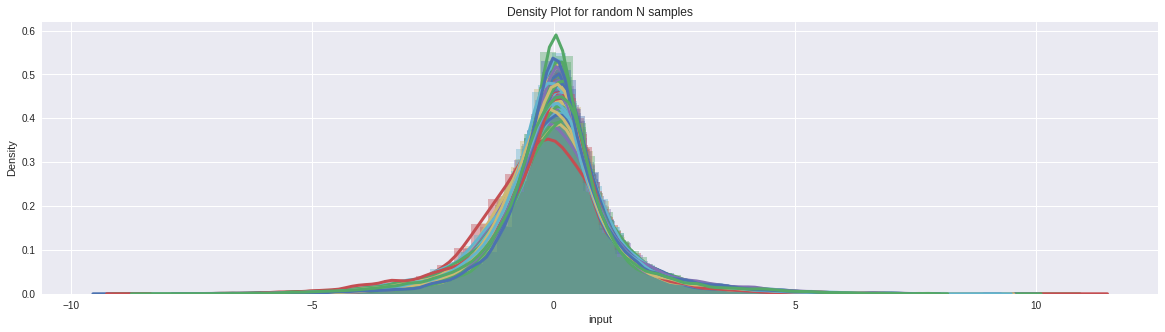

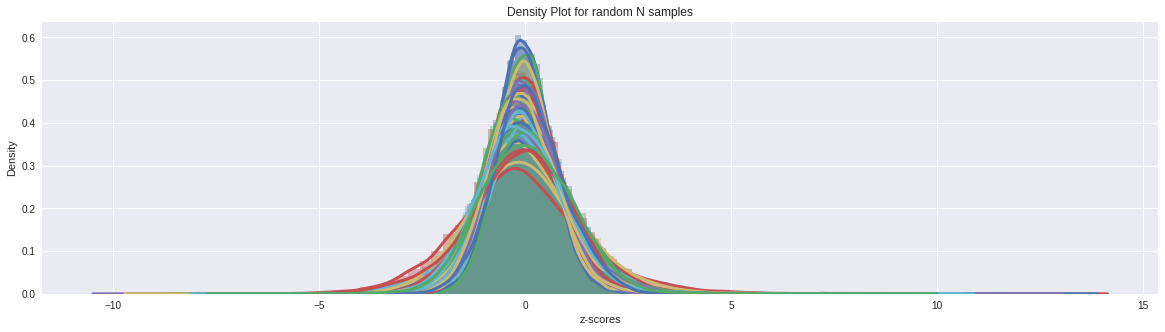

In [142]:
data_dir = "Expression/TCGA-BRCA/cbioportal/brca_tcga_provisional_1100/"
file_name = "data_expression_median.txt"
tcga_micro = filter_and_preprocess(data_dir,file_name,no_log2=True,plot_n_random=50)
tcga_micro.head()

### TCGA Samples with both microarrays and RSEM 

In [38]:
common_samples = list(set(tcga_rnaseq.columns.values).intersection(set(tcga_micro.columns.values)))
len(common_samples)

517

# METABRIC cBioPortal 
    data_expression.txt - mRNA expression (microarray);
    profile_description: Expression log intensity levels (Illumina Human v3 microarray)
    !!!data looks like RSEM or TPM quantile-normalized

Initially
samples: 1904 genes: 24368
Bad values found:
 NaN: 0 / 0.0 % Inf: 0 / 0.0 % 0: 0 / 0.0 %
NaNs will be replaced with zeroes
After removal of rows with > 95% 0s
samples: 1904 genes: 24368
After removal of duplicated rows
samples: 1904 genes: 24368
z-score in rows


,,MB-0362,MB-0346,MB-0386,MB-0574,MB-0503,MB-0641,MB-0201,MB-0218,MB-0316,MB-0189,...,MB-6122,MB-6192,MB-4820,MB-5527,MB-5167,MB-5465,MB-5453,MB-5471,MB-5127,MB-4313
Hugo_Symbol,Entrez_Gene_Id,,,,,,,,,,,,,,,,,,,,,
RERE,473.0,-0.708198,1.217889,0.016758,-0.424787,0.491610,0.515618,-1.210513,-0.930948,-0.267739,-0.205773,...,-0.545226,-0.445021,1.842898,1.109160,1.187140,-1.870188,1.129930,0.048095,-0.335656,-1.256161
RNF165,494470.0,-0.441855,0.414038,-0.684264,-1.113932,-0.687526,-0.252178,-0.412379,-0.002345,-0.890955,0.105689,...,0.953686,-1.156422,0.956323,0.047037,-0.256983,3.228967,1.360865,0.629141,0.228094,0.605112
CD049690,NaN,0.223584,0.225457,0.569077,0.354492,0.786491,-0.371529,1.935599,-0.161152,1.046100,-0.090175,...,-0.578302,-0.432888,0.592827,-1.079619,0.116330,-0.001832,0.803542,-0.617764,1.032688,0.855847
BC033982,NaN,-2.148503,0.476343,-0.244603,0.261798,-0.269477,-0.839060,-0.676953,0.985338,0.426395,0.794430,...,0.144546,-3.185417,-2.253292,1.131124,0.481908,-2.574925,-1.631424,-0.843544,-1.042855,-0.102255
PHF7,51533.0,-0.321958,-1.092059,0.282965,-0.286423,0.077215,-0.497635,-0.645303,-0.050633,-0.119066,-1.304787,...,-0.919045,-0.053890,0.745440,0.163079,0.893116,-0.948201,-0.039680,0.549108,-0.011500,4.184615


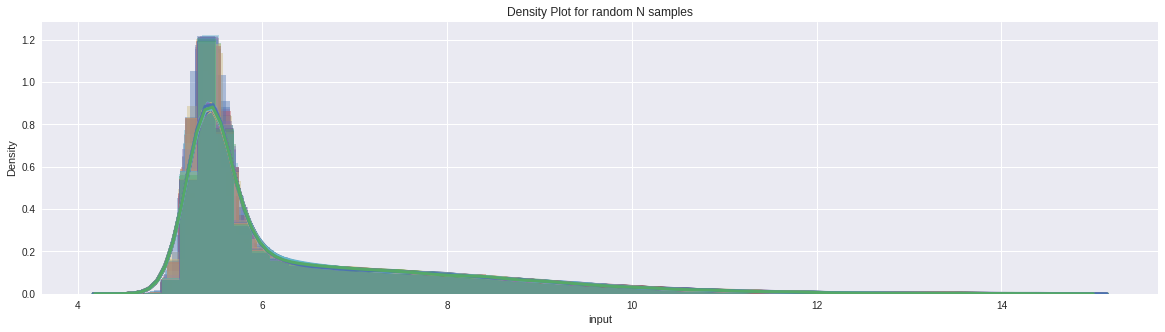

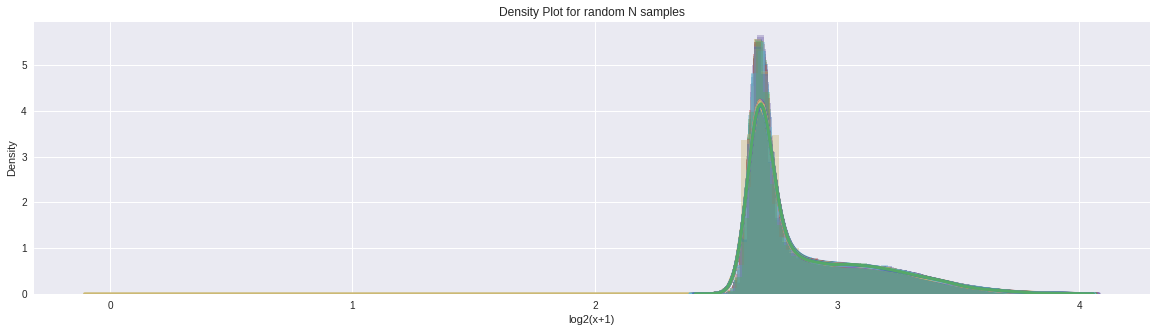

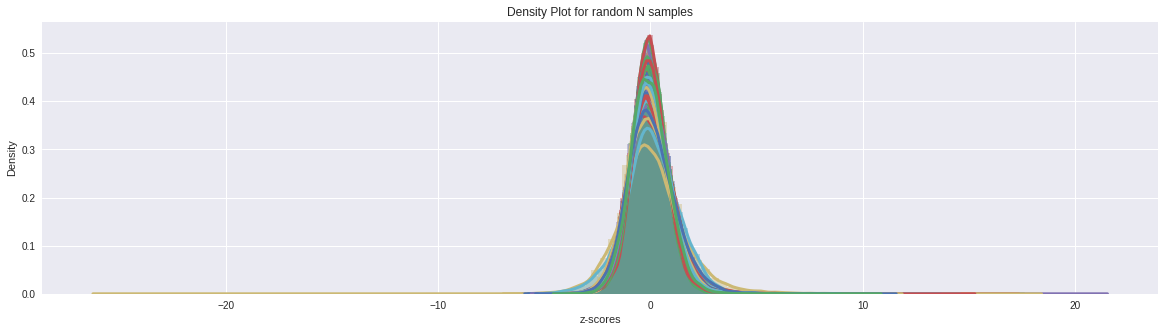

In [188]:
data_dir="Expression/METABRIC/brca_metabric/";
#rna_seq = pd.read_csv(data_dir+"data_expression.txt",sep="\t",index_col=[0,1])
metabric = filter_and_preprocess(data_dir,"data_expression.txt",plot_n_random=50)
metabric.head()

In [166]:
metabric_anno = pd.read_csv("Expression/METABRIC/brca_metabric/data_clinical_patient.unix.txt",comment="#",sep="\t",index_col=0).T
metabric_anno2 = pd.read_csv("Expression/METABRIC/brca_metabric/data_clinical_sample.unix.txt",comment="#",sep="\t",index_col=0).T
metabric_anno = pd.concat([metabric_anno,metabric_anno2])
metabric_anno.index.values

array(['OS_MONTHS', 'OS_STATUS', 'VITAL_STATUS', 'INTCLUST', 'COHORT',
       'AGE_AT_DIAGNOSIS', 'LATERALITY', 'NPI', 'ER_IHC',
       'INFERRED_MENOPAUSAL_STATE', 'BREAST_SURGERY', 'CELLULARITY',
       'HER2_SNP6', 'THREEGENE', 'CLAUDIN_SUBTYPE', 'CHEMOTHERAPY',
       'HORMONE_THERAPY', 'RADIO_THERAPY', 'HISTOLOGICAL_SUBTYPE',
       'PATIENT_ID', 'GRADE', 'TUMOR_SIZE', 'TUMOR_STAGE', 'ER_STATUS',
       'HER2_STATUS', 'PR_STATUS', 'ONCOTREE_CODE', 'SAMPLE_TYPE'], dtype=object)

### Patients with expression and annotations : 
1904

In [41]:
common_sample_names = set(metabric_anno.columns.values).intersection(set(metabric.columns.values))
len(common_sample_names)
# therefore keep only annotations for patients with expression data 
metabric_anno = metabric_anno[metabric.columns.values]

# Get common genes in METABRIC and TCGA matrices


In [42]:
common_genes =set(tcga_rnaseq.index).intersection(set(metabric.index))#.intersection(set(tcga_micro.index))
len(common_genes)

15417

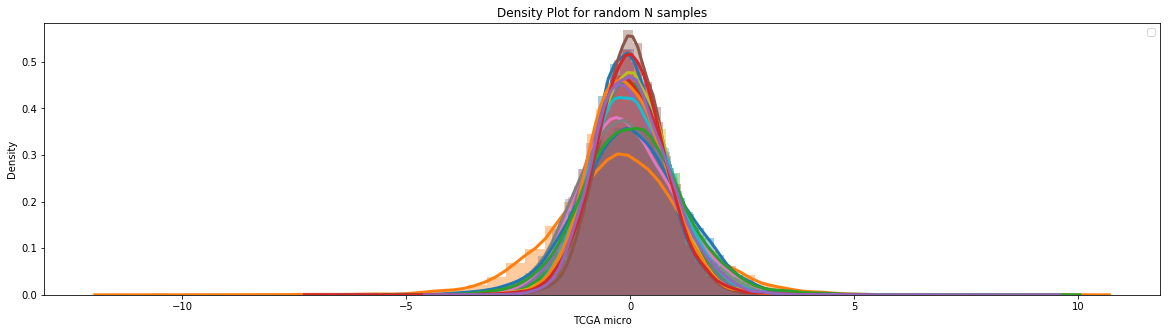

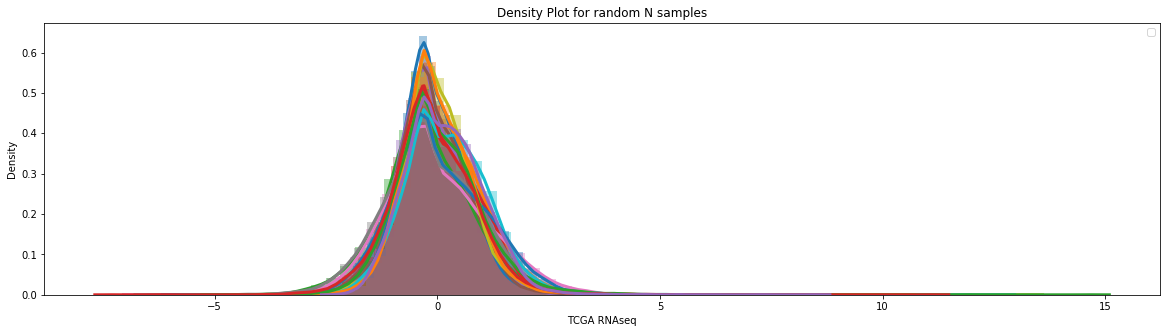

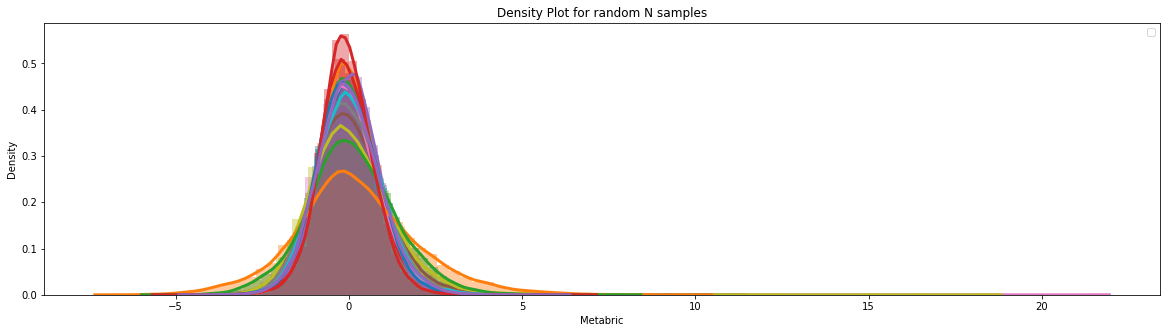

In [45]:
# plot samples with common genes only 
s= plot_n_samples(tcga_micro,n=15,label="TCGA micro")
s= plot_n_samples(tcga_rnaseq,n=s,label="TCGA RNAseq")
s= plot_n_samples(metabric,n=15,label="Metabric")

### Most of distributions look the same, but some genes look different:
e.g. "FRG2B", "HRH3", "ANKFN1" 

H0: - This is because of microarray - RNA-seq differences ? 
HA: - somthing is wrong with RNA-seq samples that have zero expression values . If it is true, perhaps later we must exclude such samples

/home/olya/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


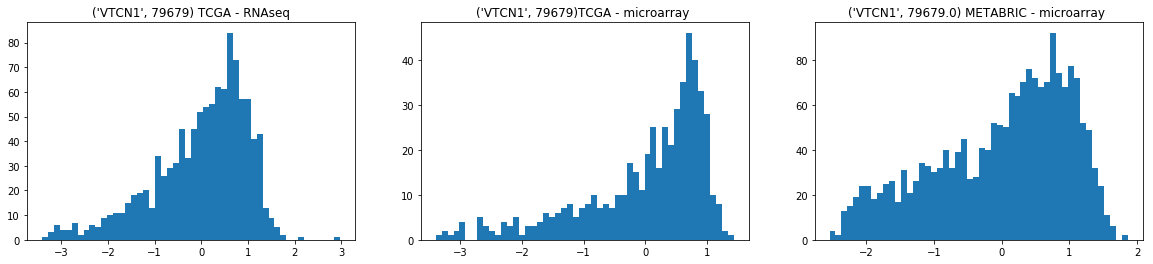

/home/olya/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/olya/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


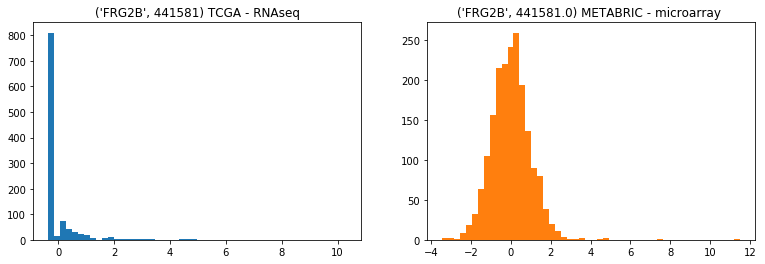

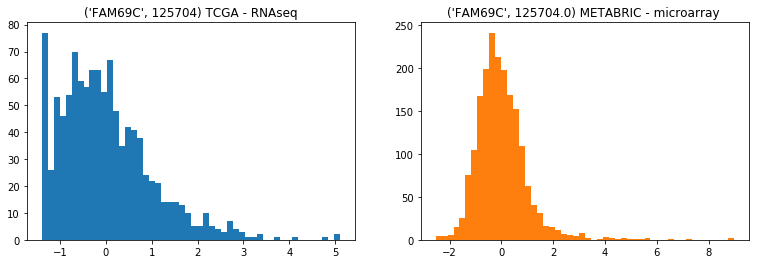

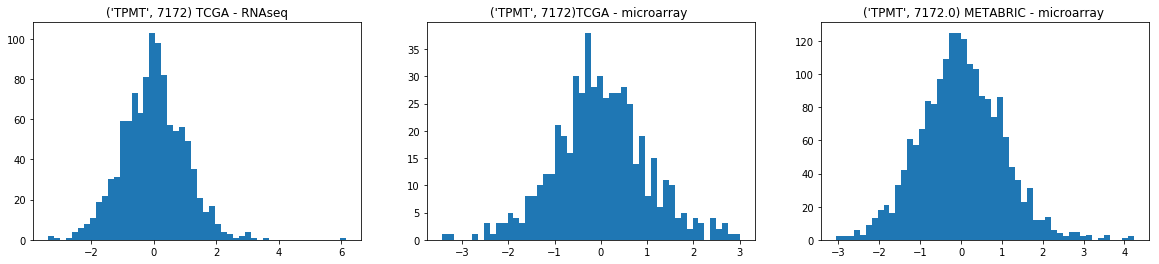

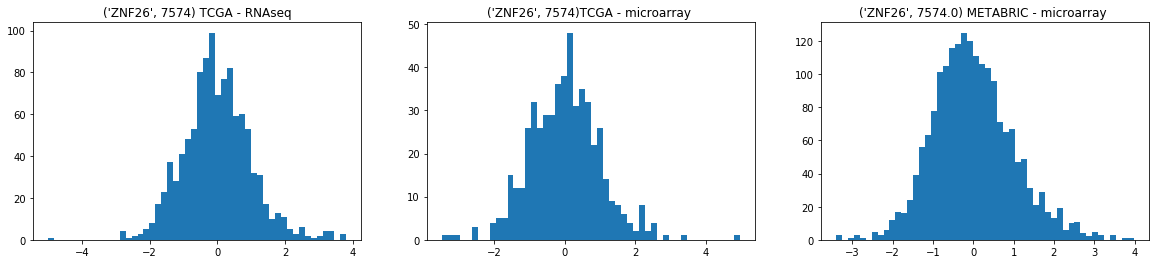

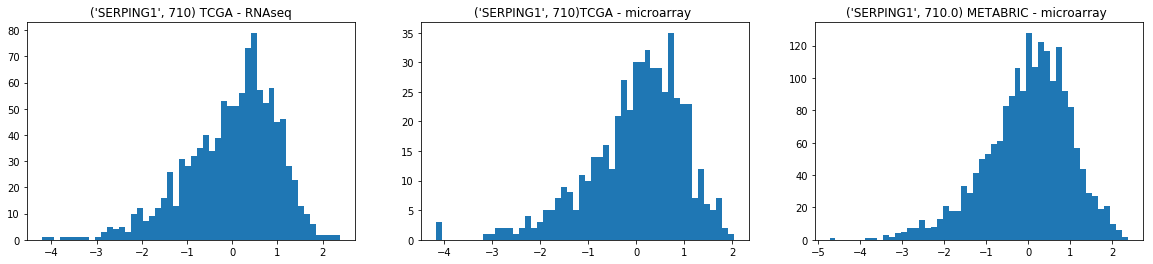

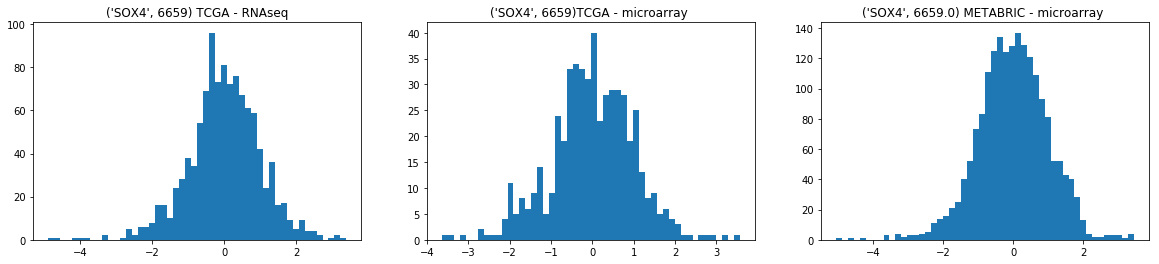

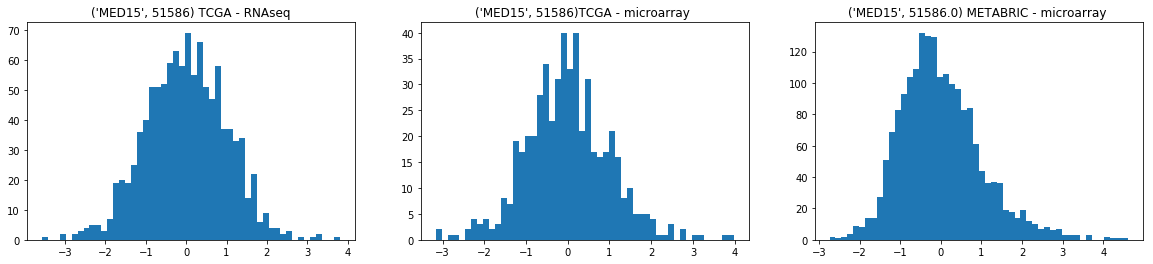

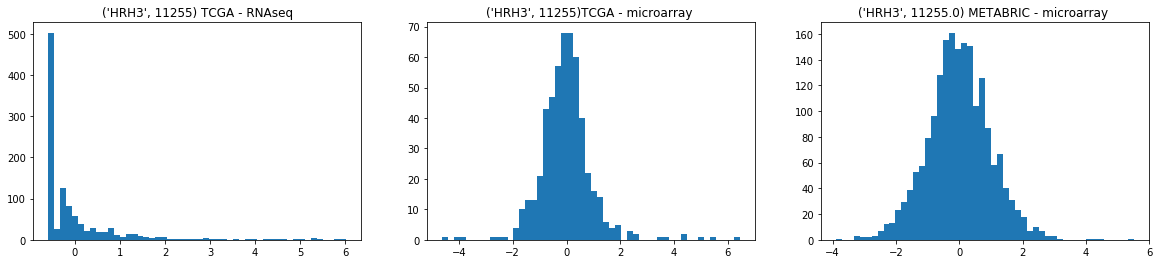

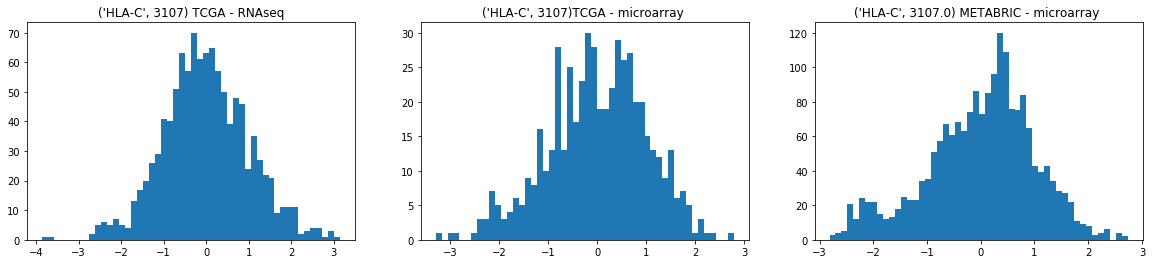

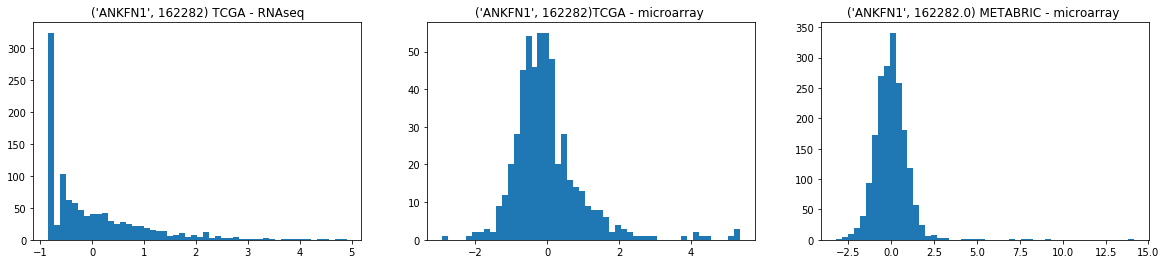

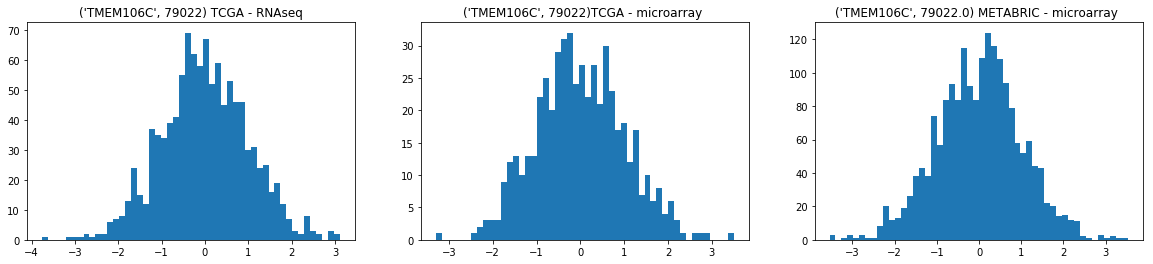

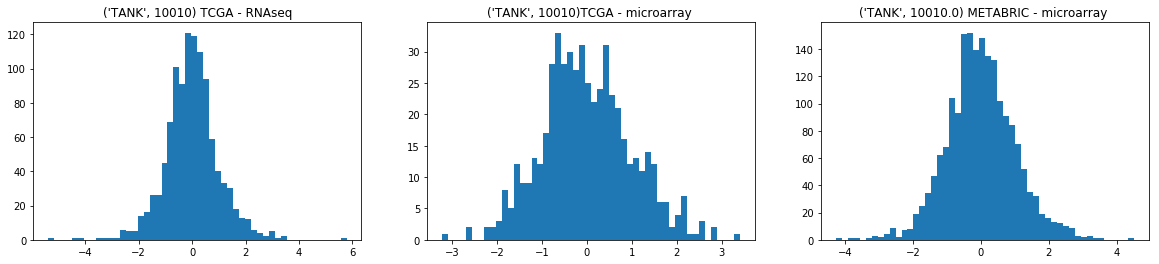

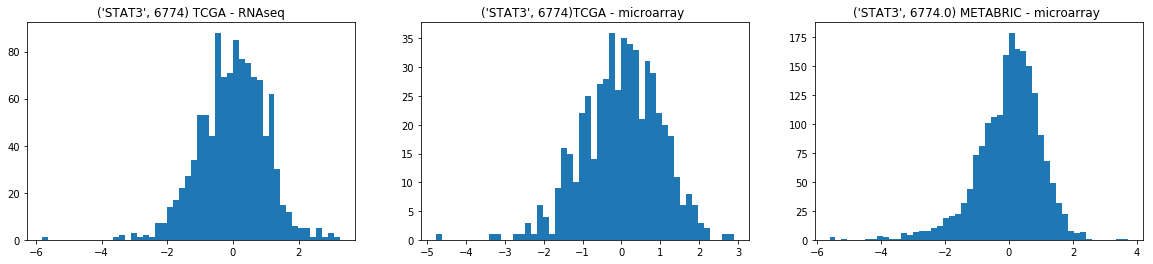

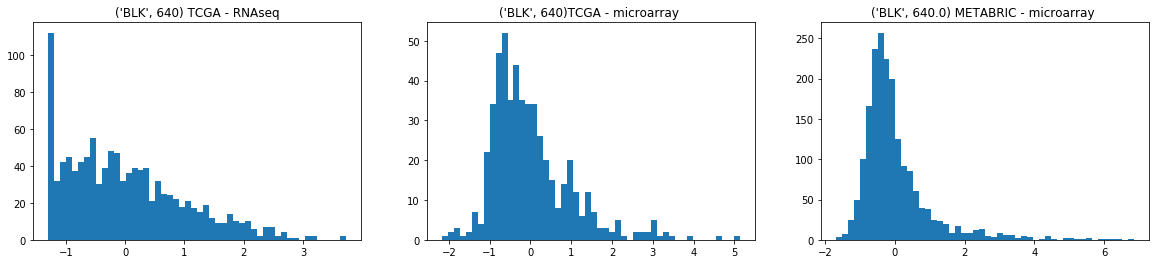

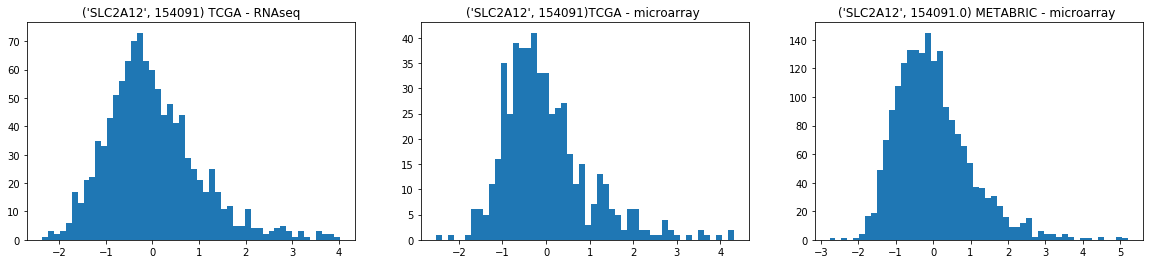

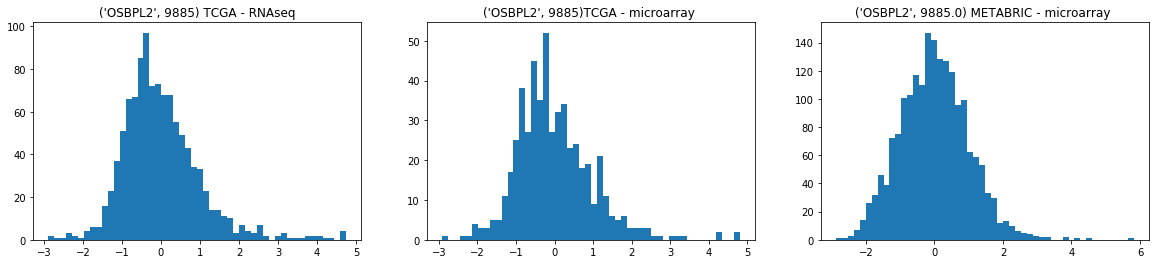

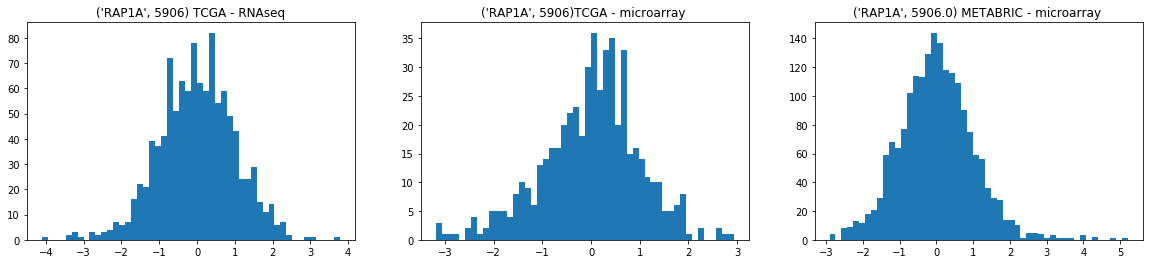

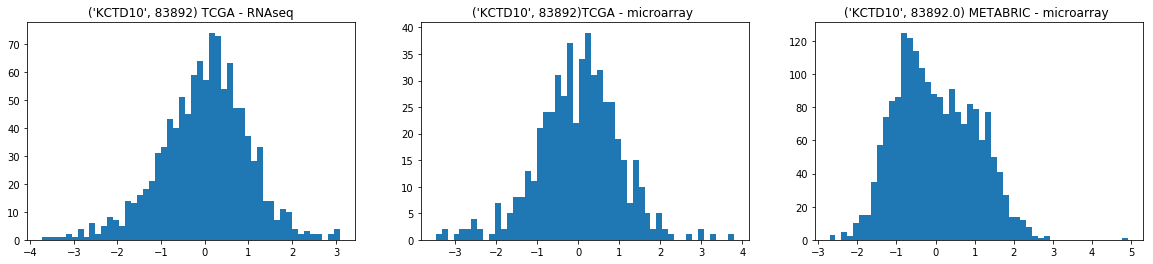

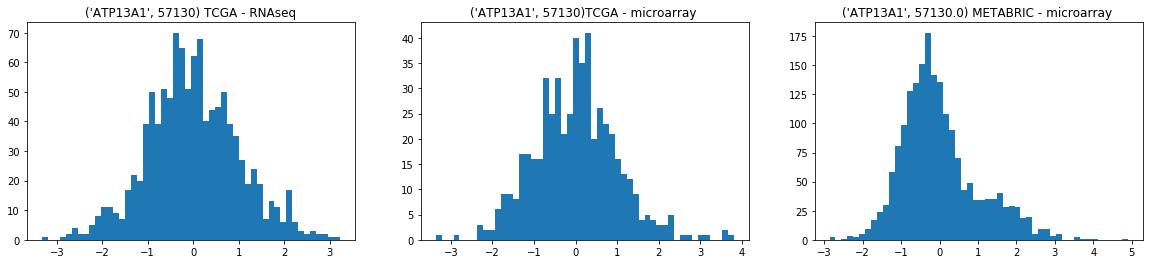

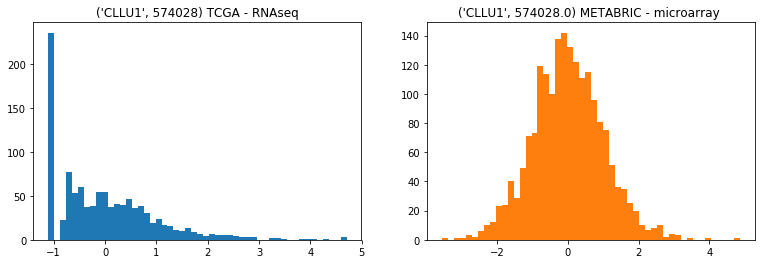

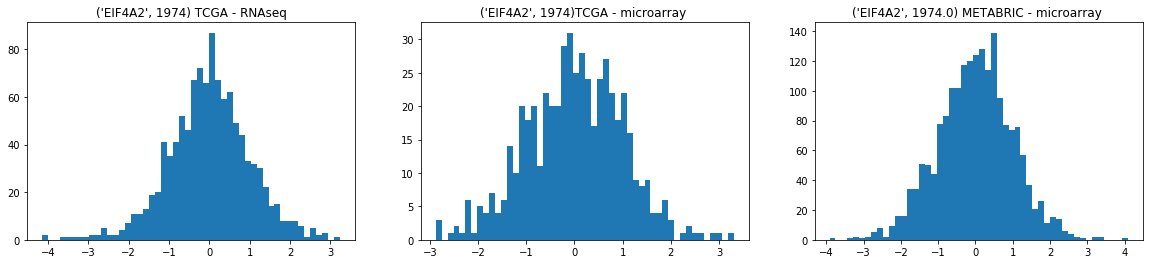

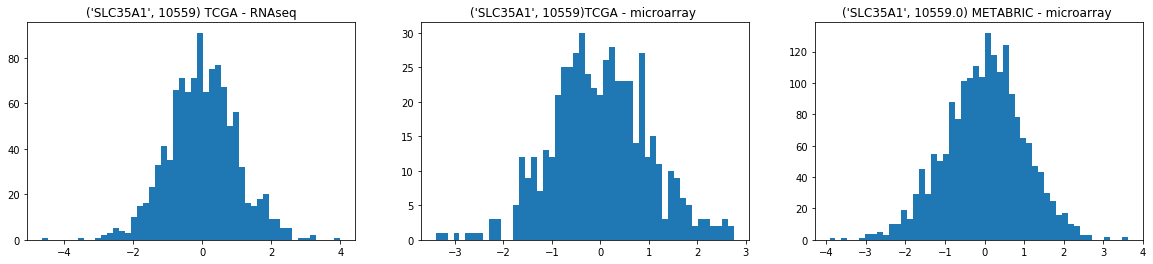

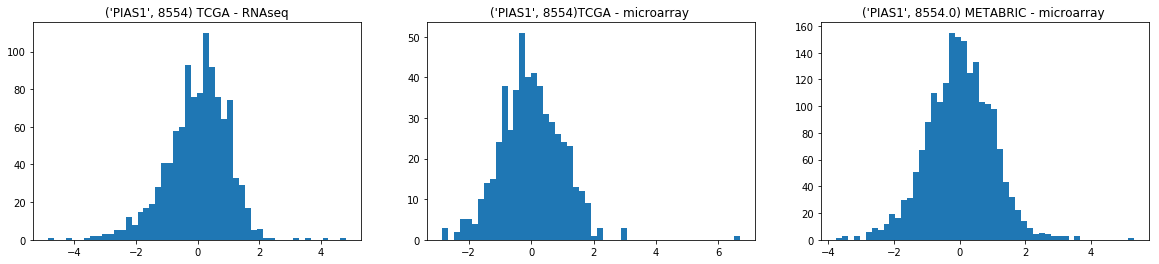

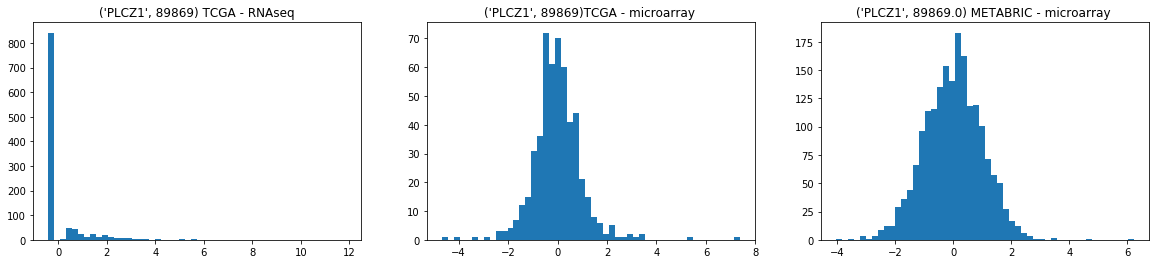

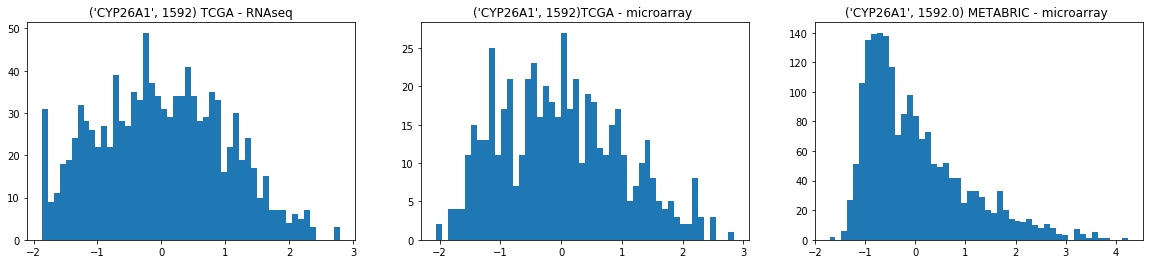

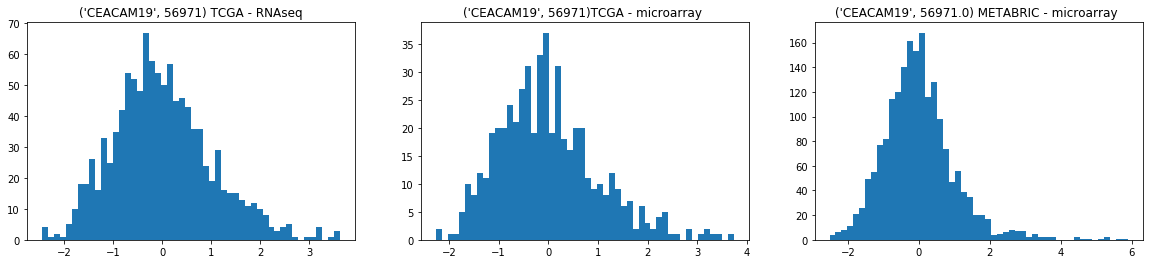

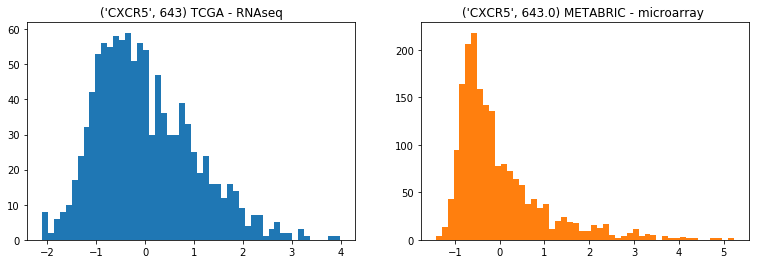

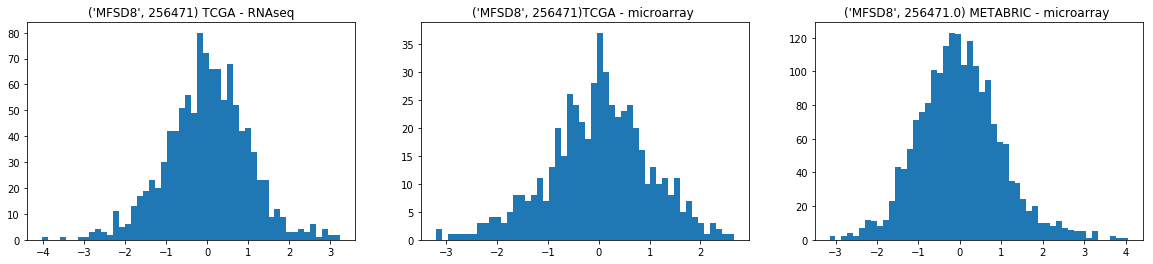

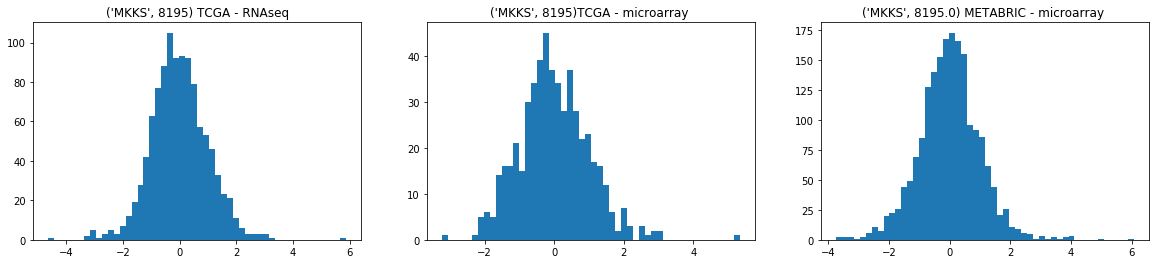

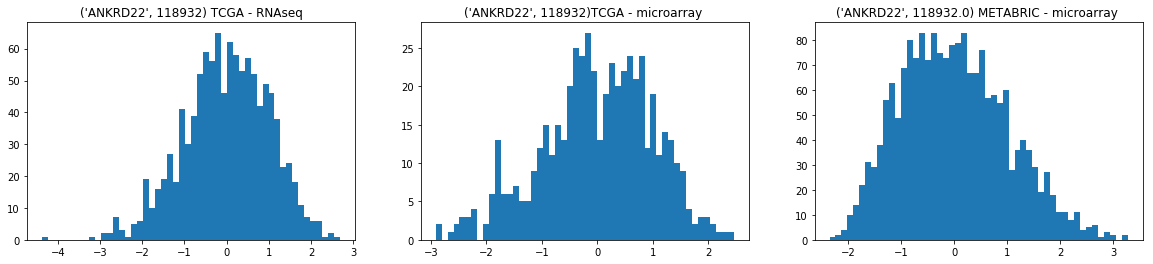

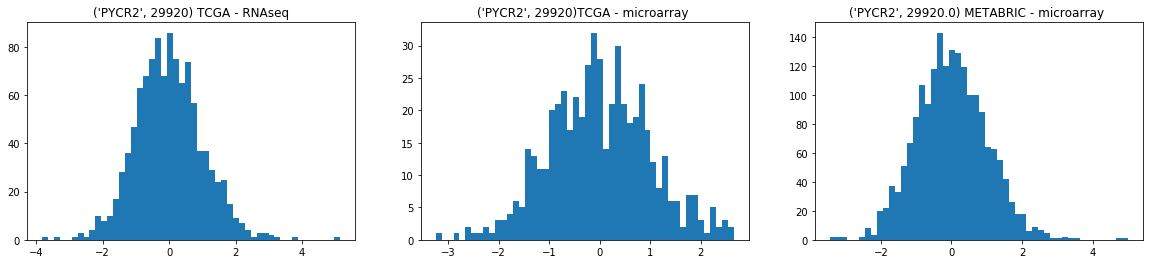

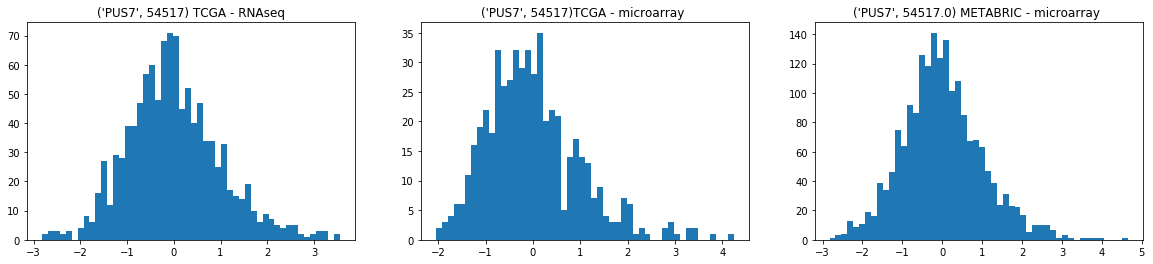

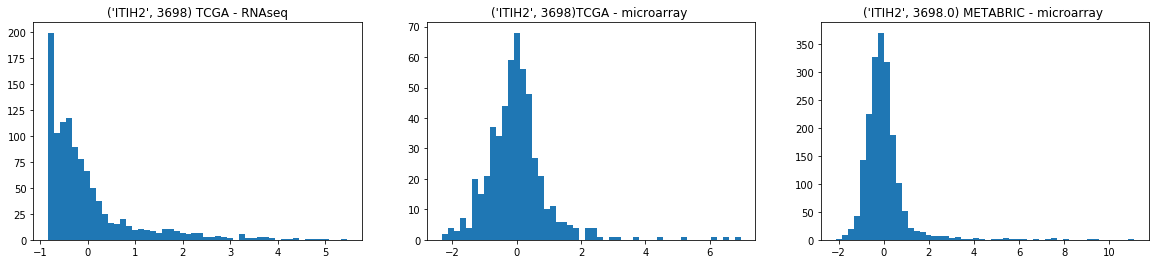

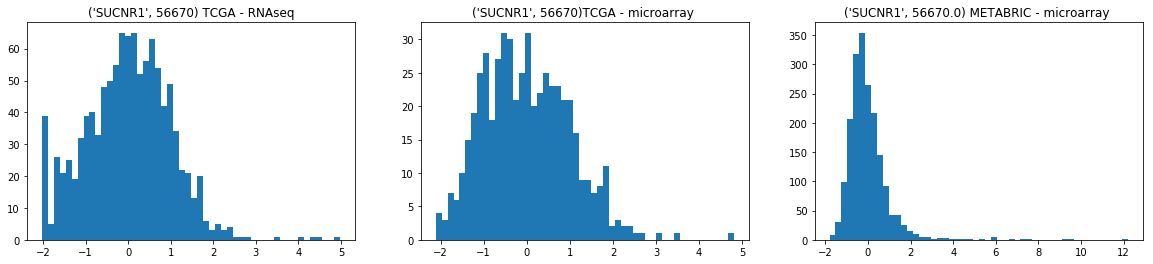

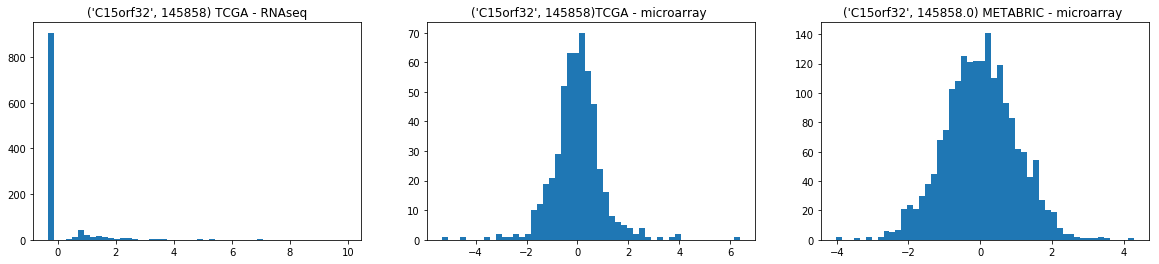

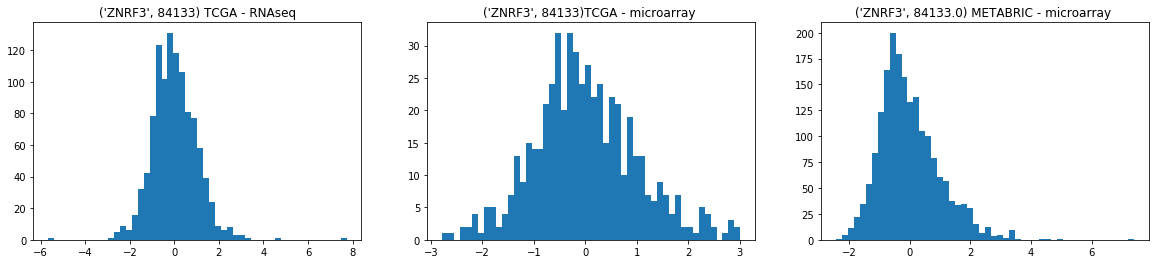

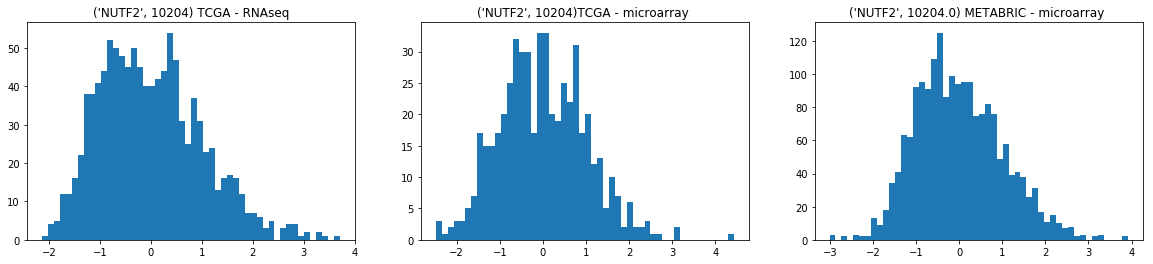

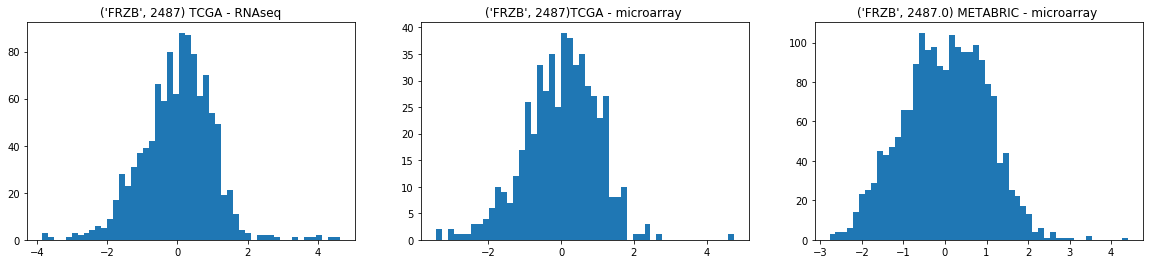

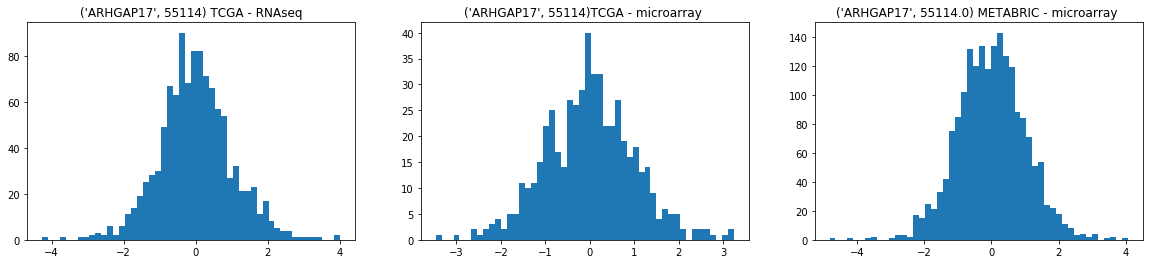

In [46]:
g = list(common_genes)[:40] 
for t,tm,m in zip(tcga_rnaseq.loc[g].iterrows(),tcga_micro.loc[g].iterrows(),metabric.loc[g].iterrows()):
    plt.figure(1,figsize=(20,4))
    plt.subplot(131)
    plt.hist(t[1],bins=50)
    plt.title(str(t[0])+ " TCGA - RNAseq")
    plt.subplot(132)
    try:
        plt.hist(tm[1],bins=50)
        plt.title(str(tm[0])+ "TCGA - microarray ")
        plt.subplot(133)
    except:
        pass
    plt.hist(m[1],bins=50)
    plt.title(str(m[0])+ " METABRIC - microarray ")
    plt.show()

# Write harmonized expressoins and annotations

In [49]:
"""tcga_rnaseq.index = tcga_rnaseq.index.droplevel(1)
tcga_rnaseq.to_csv("Expression/Harmonized/TCGA_RNAseq.RSEM.log2.z.tsv",sep="\t")
tcga_micro.index = tcga_micro.index.droplevel(1)
tcga_micro.to_csv("Expression/Harmonized/TCGA_micro_nolog2.z.tsv",sep="\t")
metabric.index = metabric.index.droplevel(1)
metabric.to_csv("Expression/Harmonized/METABRIC_micro_log2.z.tsv",sep="\t")"""

'tcga_rnaseq.index = tcga_rnaseq.index.droplevel(1)\ntcga_rnaseq.to_csv("Expression/Harmonized/TCGA_RNAseq.RSEM.log2.z.tsv",sep="\t")\ntcga_micro.index = tcga_micro.index.droplevel(1)\ntcga_micro.to_csv("Expression/Harmonized/TCGA_micro_nolog2.z.tsv",sep="\t")\nmetabric.index = metabric.index.droplevel(1)\nmetabric.to_csv("Expression/Harmonized/METABRIC_micro_log2.z.tsv",sep="\t")'

In [50]:
#k15genes = set(pd.read_csv("/home/olya/Downloads/15kGenes.csv",sep="\t",header=None)[0].values)
#print("15K gene vs BRCA RNA-seq:",len(k15genes.intersection(set([x[0] for x in tcga_rnaseq.index.values ]))))
#print("15K gene vs BRCA microarray:",len(k15genes.intersection(set([x[0] for x in tcga_micro.index.values ]))))

# HGNC genes presenting in all three matrices
 ~ 13 K in all three matrices;
 
 ~ 15K genes shared between TCGA-micro and TCGA-RNAseq 

In [51]:
common_genes = set(tcga_rnaseq.index.values).intersection(set(tcga_micro.index.values)).intersection(set(metabric.index.values))
common_genes = list(common_genes)
len(common_genes)

13361

In [52]:
"""tcga_rnaseq.loc[common_genes].to_csv("Expression/Harmonized/TCGA_RNAseq.RSEM.log2.z.13K_common.tsv",sep="\t")
tcga_micro.loc[common_genes].to_csv("Expression/Harmonized/TCGA_micro_nolog2.z.13K_common.tsv",sep="\t")
metabric.loc[common_genes].to_csv("Expression/Harmonized/METABRIC_micro_log2.z.13K_common.tsv",sep="\t")"""

# Harmonizing annotations in TCGA and METABRIC 


In [267]:
#tcga_anno.index.values
tcga_anno.index.values

array(['PATIENT_ID', 'AGE', 'GENDER', 'ETHNICITY', 'RACE', 'SUBTYPE',
       'CANCER_TYPE_ACRONYM', 'ONCOTREE_CODE', 'CANCER_TYPE',
       'CANCER_TYPE_DETAILED', 'TUMOR_TYPE', 'DAYS_LAST_FOLLOWUP',
       'DAYS_TO_BIRTH', 'DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS',
       'ICD_O_3_HISTOLOGY', 'AJCC_PATHOLOGIC_TUMOR_STAGE', 'PATH_T_STAGE',
       'PATH_M_STAGE', 'PATH_N_STAGE',
       'PRIMARY_LYMPH_NODE_PRESENTATION_ASSESSMENT', 'GRADE',
       'HISTORY_NEOADJUVANT_TRTYN', 'RADIATION_THERAPY',
       'PERSON_NEOPLASM_CANCER_STATUS', 'PRIOR_DX',
       'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT', 'WEIGHT', 'CENTER',
       'Sex', 'Diagnosis Age', 'Menopause Status',
       'Initial Patient Weight', 'Ethnicity Category', 'Race Category',
       'Tumor Disease Anatomic Site', 'Cancer Type',
       'Cancer Type Detailed', 'Oncotree Code',
       'Neoplasm Histologic Type Name',
       'American Joint Committee on Cancer Metastasis Stage Code',
       'American Joint Committee on Cancer Tumor St

In [55]:
metabric_anno.index.values

array(['OS_MONTHS', 'OS_STATUS', 'VITAL_STATUS', 'INTCLUST', 'COHORT',
       'AGE_AT_DIAGNOSIS', 'LATERALITY', 'NPI', 'ER_IHC',
       'INFERRED_MENOPAUSAL_STATE', 'BREAST_SURGERY', 'CELLULARITY',
       'HER2_SNP6', 'THREEGENE', 'CLAUDIN_SUBTYPE', 'CHEMOTHERAPY',
       'HORMONE_THERAPY', 'RADIO_THERAPY', 'HISTOLOGICAL_SUBTYPE',
       'PATIENT_ID', 'GRADE', 'TUMOR_SIZE', 'TUMOR_STAGE', 'ER_STATUS',
       'HER2_STATUS', 'PR_STATUS', 'ONCOTREE_CODE', 'SAMPLE_TYPE'],
      dtype=object)

# Harmonizing annotation formats in TCGA and METABRIC

## Variables available in both cohorts:
### TODO:
 - primary or metastatic sample itself (METABRIC - all primary)

#### Tumor subtyping 
* **Histological subtype (hist_subtype)**  - 
In TCGA "ONCOTREE_CODE" nearly match with 'Neoplasm Histologic Type Name' and 'TUMOR_TYPE', but in METABRIC "HISTOLOGICAL_SUBTYPE" disagrees with "ONCOTREE_CODE".
* **Oncotree code (oncotree)** 
Oncotree codes are different in TCGA and METABRIC, except IDC and LC.
* **Molecular subtype  (mol_subtype)**
* **Stage (stage)**


#### Histology 
Whether patient IHC-positive or negative for ER,HER2 and PR.
* **ER and PR** in TCGA: Negative-0, Indeterminate-1, Positive-2
* **HER2** in TCGA:  Negative, Equivocal, Indeterminate, Positive
In METABRIC only +- for all

(keratin staining provided only for some TCGA patients)

#### Patient characteristics 
* **Diagnosis Age** (diagnosis_age)  - age of onset in years 
* **Sex** - F/M (all F in TCGA, assume all F in METABRIC, although not reported)
* **Menopause Status (menopause_status)** -
In metabric only 'pre' and 'post' groups. In TCGA 4 groups:
        - Indeterminate (neither Pre or Postmenopausal) 
        - Peri (6-12 months since last menstrual period) 
        - Post (prior bilateral ovariectomy OR >12 mo since LMP with no prior hysterectomy)
        - Pre (\<6 months since LMP AND no prior bilateral ovariectomy AND not on estrogen replacement)


#### Survival 
* **OS month and OS Status** - how many months a patient was observed and wheter alive (0) or dead (1) at the end of this period

#### technical 
 **cohort**
 
#### Only TCGA 
* **Age** (age) - age in years 
* **Race** 
* **Ethnicity Category (is_hispanic_or_latino)** 1 - if Hispanic or Latino, 0 otherwise
* **PFS and PFS stauts** - How many months a patient was observed and wheter progression happened during this period of time 
* **Tumor Stage (t_stage)**
* **Metastatic stage (m_stage)**
* **Lymph node stage (n_stage)**
* technical details

#### Only METABRIC
* Grade (grade)

In [268]:
tcga_dict = {"age":"AGE","diagnosis_age":"Diagnosis Age","race":"Race Category","is_hispanic_or_latino":"ETHNICITY",
             "sex":"Sex",'menopause_status':"Menopause Status",
             "mol_subt":"SUBTYPE","hist_subt":'TUMOR_TYPE',"oncotree":"ONCOTREE_CODE",
             "stage":'AJCC_PATHOLOGIC_TUMOR_STAGE',"t_stage":'PATH_T_STAGE',"m_stage":'PATH_M_STAGE',"n_stage":'PATH_N_STAGE',
             "OS":'Overall Survival (Months)', "OS_status":'Overall Survival Status',
              "ER":'ER Status By IHC',"HER2":'IHC-HER2',"PR":'PR status by ihc',"cohort":'Tissue Source Site'}

# ER_IHC!= ER_status != THREEGENE 
# 'CLAUDIN_SUBTYPE' == molecular subtype 
metabric_dict = {"diagnosis_age":'AGE_AT_DIAGNOSIS',"menopause_status":"INFERRED_MENOPAUSAL_STATE",
               "mol_subt":"CLAUDIN_SUBTYPE","hist_subt":"HISTOLOGICAL_SUBTYPE","oncotree":"ONCOTREE_CODE",
                "stage":'TUMOR_STAGE',
                "OS":'OS_MONTHS', "OS_status":'OS_STATUS',
                "ER":"ER_STATUS","HER2":'HER2_STATUS',"PR":'PR_STATUS',
                "cohort":'COHORT',
                "grade":"GRADE",
                'chemo_therapy':'CHEMOTHERAPY','hormone_therapy':'HORMONE_THERAPY', 'radio_therapy':'RADIO_THERAPY'}
        
common_vars = ["diagnosis_age","menopause_status",
               "hist_subt","mol_subt","oncotree",
              "stage",
              "OS", "OS_status",
              "ER","HER2","PR",
              "cohort"]

tcga_spec_vars = ["age","race","is_hispanic_or_latino","sex",
                  "t_stage","m_stage","n_stage",]
metabric_spec_vars = ["grade",'chemo_therapy','hormone_therapy', 'radio_therapy'] # 'INTCLUST','HER2_SNP6','CHEMOTHERAPY','HORMONE_THERAPY', 'RADIO_THERAPY','VITAL_STATUS',ER_IHC,THREEGENE 
#! other important variables : 
# TCGA 
#set(tcga_anno.loc['CENTER'].values)

### Metabric 
#'CLAUDIN_SUBTYPE',
#'ER_STATUS','HER2_STATUS','PR_STATUS','HER2_SNP6','ER_IHC','THREEGENE', 
#'COHORT','SAMPLE_TYPE'
# ! Survival from both 

In [269]:
################ TCGA ######################
tcga_samples = list(set(tcga_rnaseq.columns.values).union(set(tcga_micro.columns.values)).intersection(set(tcga_anno.columns.values)))
u_tcga_anno = tcga_anno[tcga_samples]
u_tcga_anno = u_tcga_anno.loc[tcga_dict.values()]
inv_tcga_dict = {v: k for k, v in tcga_dict.iteritems()}
u_tcga_anno.rename(inv_tcga_dict,inplace=True)
u_tcga_anno = u_tcga_anno.loc[common_vars+tcga_spec_vars,:]
#u_tcga_anno.T.isnull().sum()#.T.groupby(["HER2"]).size()
################ METABRIC ####################
metabric_samples = list(set(metabric.columns.values).intersection(set(metabric_anno.columns.values)))
u_metabric_anno = metabric_anno[metabric_samples]
u_metabric_anno = u_metabric_anno.loc[metabric_dict.values()]
inv_metabric_dict = {v: k for k, v in metabric_dict.iteritems()}
u_metabric_anno.rename(inv_metabric_dict,inplace=True)
u_metabric_anno = u_metabric_anno.loc[common_vars+metabric_spec_vars,:]
##############################################

#### fill NA in categorical with NA
ndx_to_replace_na = ["menopause_status","mol_subt","stage","OS_status","ER","HER2","PR","cohort",
                     "race","is_hispanic_or_latino","sex"]
u_tcga_anno.loc[ndx_to_replace_na,:] = u_tcga_anno.loc[ndx_to_replace_na,:].fillna("NA")
##### menopause
menopause_status = {"NA":"NA",'Indeterminate (neither Pre or Postmenopausal)':"NA",
                    'Peri (6-12 months since last menstrual period)':"peri",
                    'Post (prior bilateral ovariectomy OR >12 mo since LMP with no prior hysterectomy)':"post",
                    'Pre (<6 months since LMP AND no prior bilateral ovariectomy AND not on estrogen replacement)':"pre"}
u_tcga_anno.loc["menopause_status",:] = u_tcga_anno.loc["menopause_status",:].apply(lambda x : menopause_status[x])
print("Menopause")
print("\tTCGA:",set(u_tcga_anno.loc["menopause_status"].values),
      "\n\tMETABRIC:", set(u_metabric_anno.loc['menopause_status'].values))
##### subtypes 
u_tcga_anno.loc["mol_subt"] = u_tcga_anno.loc["mol_subt"].apply(lambda x : x.replace("BRCA_",""))
print("Mol. Subtypes")
print("\tTCGA:",set(u_tcga_anno.loc["mol_subt"].values), "\n\tMETABRIC:", set(u_metabric_anno.loc['mol_subt'].values))
print("Hist. Subtypes")
u_metabric_anno.loc["hist_subt"] = u_metabric_anno.loc["hist_subt"].replace({'null':"NA"})
print("\tTCGA:",set(u_tcga_anno.loc["hist_subt"].values), "\n\tMETABRIC:", set(u_metabric_anno.loc['hist_subt'].values))
print("Oncotree. Subtypes")
print("\tTCGA:",set(u_tcga_anno.loc["oncotree"].values), "\n\tMETABRIC:", set(u_metabric_anno.loc['oncotree'].values))
#### stage
mapper = {'NA':'NA','STAGE I':1,'STAGE IA':1,'STAGE IB':1,'STAGE IC':1,
         'STAGE II':2,'STAGE IIA':2,'STAGE IIB':2,'STAGE IIC':2,
         'STAGE III':3,'STAGE IIIA':3,'STAGE IIIB':3,'STAGE IIIC':3,
         'STAGE IV':4,'STAGE IVA':4,'STAGE IVB':4,'STAGE IVC':4,
         'STAGE X':'X'}
u_tcga_anno.loc["stage"] = u_tcga_anno.loc["stage"].apply(lambda x : mapper[x])
mapper = {'null':'NA','0':0,'1':1,'2':2,'3':3,'4':4}
u_metabric_anno.loc["stage"] = u_metabric_anno.loc["stage"].apply(lambda x : mapper[x])
print("Stages")
print("\tTCGA:",set(u_tcga_anno.loc["stage"] .values), "\n\tMETABRIC:", set(u_metabric_anno.loc['stage'].values))
#### OS 
print("OS status")
print("\tTCGA:",set(u_tcga_anno.loc["OS_status"] .values), "\n\tMETABRIC:", set(u_metabric_anno.loc['OS_status'].values))
##### IHC #####
u_metabric_anno.loc[["ER","HER2","PR"],:] = u_metabric_anno.loc[["ER","HER2","PR"],:].replace({"+":"Positive","-":"Negative"})
print("ER")
print("\tTCGA:",set(u_tcga_anno.loc["ER"] .values), "\n\tMETABRIC:", set(u_metabric_anno.loc['ER'].values))
print("HER2")
print("\tTCGA:",set(u_tcga_anno.loc["HER2"] .values), "\n\tMETABRIC:", set(u_metabric_anno.loc['HER2'].values))
print("PR")
print("\tTCGA:",set(u_tcga_anno.loc["PR"] .values), "\n\tMETABRIC:", set(u_metabric_anno.loc['PR'].values))
u_tcga_anno

Menopause
	TCGA: set(['pre', 'NA', 'post', 'peri']) 
	METABRIC: set(['pre', 'post'])
Mol. Subtypes
	TCGA: set(['Normal', 'NA', 'Basal', 'Her2', 'LumB', 'LumA']) 
	METABRIC: set(['Normal', 'NC', 'Basal', 'Her2', 'LumB', 'claudin-low', 'LumA'])
Hist. Subtypes
	TCGA: set(['Breast Invasive Carcinoma', 'Infiltrating Carcinoma (NOS)', 'Infiltrating Ductal Carcinoma', 'Mixed Histology (NOS)', 'Metaplastic Carcinoma', 'Mucinous Carcinoma', 'Other', 'Medullary Carcinoma', 'Infiltrating Lobular Carcinoma']) 
	METABRIC: set(['INVASIVE TUMOUR', 'IDC+ILC', 'IDC-MUC', 'ILC', 'NA', 'MIXED NST AND A SPECIAL TYPE', 'OTHER INVASIVE', 'BENIGN', 'OTHER', 'IDC-MED', 'IDC-TUB', 'DCIS', 'IDC'])
Oncotree. Subtypes
	TCGA: set(['ILC', 'IMMC', 'MBC', 'BRCNOS', 'BRCA', 'IDC']) 
	METABRIC: set(['ILC', 'MDLC', 'BREAST', 'BRCA', 'DCIS', 'IDC'])
Stages
	TCGA: set([1, 2, 3, 4, 'NA', 'X']) 
	METABRIC: set([0, 1, 2, 3, 4, 'NA'])
OS status
	TCGA: set(['LIVING', 'DECEASED', 'NA']) 
	METABRIC: set(['LIVING', 'DECEASED'])
E

,TCGA-OL-A66H-01,TCGA-3C-AALK-01,TCGA-AR-A1AH-01,TCGA-AC-A5EH-01,TCGA-EW-A2FW-01,TCGA-E9-A1R0-01,TCGA-B6-A2IU-01,TCGA-AR-A1AJ-01,TCGA-A7-A13G-01,TCGA-AC-A62Y-01,...,TCGA-E2-A1IG-01,TCGA-EW-A6SC-01,TCGA-B6-A0IA-01,TCGA-E9-A1NH-01,TCGA-EW-A6SA-01,TCGA-BH-A0C3-01,TCGA-BH-A1F0-01,TCGA-A8-A06Q-01,TCGA-BH-A0GZ-01,TCGA-AR-A0U0-01
diagnosis_age,NaN,52,51,76,52,58,62,83,79,79,...,45,60,51,71,59,47,80,63,62,73
menopause_status,post,NA,post,NA,post,post,NA,post,post,post,...,pre,NA,NA,post,NA,pre,post,post,post,post
hist_subt,Mucinous Carcinoma,Infiltrating Ductal Carcinoma,Infiltrating Ductal Carcinoma,Infiltrating Ductal Carcinoma,Other,Infiltrating Ductal Carcinoma,Infiltrating Lobular Carcinoma,Infiltrating Ductal Carcinoma,Infiltrating Ductal Carcinoma,Infiltrating Lobular Carcinoma,...,Infiltrating Ductal Carcinoma,Infiltrating Lobular Carcinoma,Other,Infiltrating Ductal Carcinoma,Infiltrating Ductal Carcinoma,Mixed Histology (NOS),Infiltrating Ductal Carcinoma,Infiltrating Ductal Carcinoma,Infiltrating Ductal Carcinoma,Infiltrating Ductal Carcinoma
mol_subt,LumA,LumA,Basal,Her2,LumB,LumA,LumA,Basal,LumA,LumA,...,LumA,LumA,LumA,LumA,NA,LumB,Basal,LumB,LumA,Basal
oncotree,IMMC,IDC,IDC,IDC,BRCNOS,IDC,ILC,IDC,IDC,ILC,...,IDC,ILC,BRCNOS,IDC,IDC,BRCNOS,IDC,IDC,IDC,IDC
stage,1,1,2,2,2,2,2,1,2,2,...,2,2,2,2,2,1,2,3,2,2
OS,NaN,47.57,125.07,16.79,22.08,28.25,170.04,100.92,23.59,17.41,...,70.3,31.27,275.66,18.92,16.75,88.99,25.79,1.02,10.78,65.31
OS_status,LIVING,LIVING,LIVING,LIVING,LIVING,LIVING,LIVING,LIVING,LIVING,LIVING,...,LIVING,LIVING,LIVING,LIVING,LIVING,LIVING,DECEASED,LIVING,LIVING,LIVING
ER,Positive,Positive,Positive,Positive,Positive,NA,Positive,Positive,Positive,Positive,...,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Positive,Positive,Negative
HER2,NA,Positive,Negative,Negative,Negative,NA,NA,Negative,Negative,Negative,...,Negative,Negative,NA,Negative,Negative,Negative,Negative,Negative,Equivocal,NA


In [270]:
u_metabric_anno

,MB-5489,MB-5482,MB-5483,MB-5481,MB-5486,MB-5484,MB-5485,MB-5645,MB-5646,MB-5647,...,MB-0346,MB-0344,MB-0345,MB-0348,MB-0349,MB-0184,MB-0180,MB-0181,MB-0188,MB-0189
diagnosis_age,53.6,40.75,44.5,57.62,75.65,47.3,80.08,71.31,58.4,65.43,...,32.61,59.75,37.3,81.88,72.26,68.41,51.69,68.45,82.65,57.79
menopause_status,post,pre,pre,post,post,pre,post,post,post,post,...,pre,post,pre,post,post,post,post,post,post,post
hist_subt,IDC,IDC,IDC,IDC,IDC,IDC+ILC,IDC,IDC,IDC,IDC,...,IDC,ILC,IDC,IDC,IDC,IDC-MUC,IDC,IDC,ILC,IDC
mol_subt,LumA,Basal,Her2,LumB,LumB,LumA,LumB,LumA,LumB,LumA,...,Her2,Normal,LumA,LumA,LumB,LumA,LumA,LumA,Her2,Normal
oncotree,IDC,IDC,IDC,IDC,IDC,MDLC,IDC,IDC,IDC,IDC,...,IDC,ILC,IDC,IDC,IDC,BRCA,IDC,IDC,ILC,IDC
stage,1,2,2,2,2,1,2,1,2,2,...,2,2,2,2,2,2,1,2,2,4
OS,216.967,17.6667,42.4333,46.3667,123.3,238.5,31.8,22.2333,167.1,30.8,...,20.4333,152.933,72.6667,122.7,146.033,109.033,62.3333,85.9667,31.3,9.06667
OS_status,LIVING,DECEASED,DECEASED,DECEASED,DECEASED,LIVING,DECEASED,DECEASED,DECEASED,DECEASED,...,DECEASED,LIVING,LIVING,DECEASED,DECEASED,LIVING,LIVING,LIVING,DECEASED,DECEASED
ER,Positive,Positive,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Negative,Positive
HER2,Negative,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Negative,Negative,...,Positive,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative


In [278]:
#### write output
"""
u_metabric_anno.to_csv("Expression/Harmonized/METABRIC.annotation_v2.tsv",sep="\t")
u_tcga_anno.to_csv("Expression/Harmonized/TCGA.annotation_v2.tsv",sep="\t")
u_metabric_anno.T.to_csv("Expression/Harmonized/METABRIC.annotation_v2.t.tsv",sep="\t")
u_tcga_anno.T.to_csv("Expression/Harmonized/TCGA.annotation_v2.t.tsv",sep="\t")
"""